# Capítulo 3 - Analisando os dados

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))

#utils
import paths

#main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
%matplotlib inline

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

#Light GBM
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#models
from src.models import train_model
from src.models import evaluation

#visualization
from src.visualization import visualize

#validation
from src.validation import metrics
from src.validation import metrics_description

#min cols
min_cols = ["Feat_exp_max", 'Std_Dev', 'corr_with_example_preds']

In [4]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMRanker

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import XGBRanker

# Dados

In [11]:
%%time
df_training,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=True, 
                                                    dataset="training", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 309.15 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target_kazutsugi
dtypes: float16(311), int32(1), object(2)
memory usage: 307.2+ MB
None
CPU times: user 51 s, sys: 1min 13s, total: 2min 4s
Wall time: 3min 35s


In [5]:
%%time
df_validation,features,target = make_dataset.get_data(nrows=None,
                                                    low_memory=False, 
                                                    dataset="validation", 
                                                    feather=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106895 entries, 0 to 106894
Columns: 314 entries, id to target_kazutsugi
dtypes: float32(311), int32(1), object(2)
memory usage: 128.9+ MB
None
CPU times: user 668 ms, sys: 857 ms, total: 1.52 s
Wall time: 1.61 s


In [28]:
print(memory_usage.memory())

Available memory (%): 18.303871154785156
None


validation

In [9]:
df_validation = df_tournament[df_tournament.data_type == 'validation']
df_validation['era'] = df_validation.loc[:, 'era'].str[3:].astype('int32')

### Nomi

In [5]:
%%time
df_training,df_validation,features,target = \
                          make_dataset.get_data_nomi(nrows=None,
                                                    low_memory=True, 
                                                    dataset="nomi", 
                                                    feather=True)

low memory activated
Memory usage after optimization is: 376.17 MB
Decreased by 49.1%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608703 entries, 0 to 608702
Columns: 315 entries, id to target_nomi
dtypes: float16(312), int32(1), object(2)
memory usage: 373.8+ MB
None
CPU times: user 1min, sys: 1min 17s, total: 2min 18s
Wall time: 3min 5s


## Conjunto de dados (treino)

In [31]:
df_training.head() #.iloc[:,:-1]

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n000315175b67977,1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [13]:
# The features are grouped together into 6 types
feature_groups = {
    g: [c for c in df_training if c.startswith(f"feature_{g}")]
    for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]
}

In [14]:
for group, f_list in feature_groups.items():
    print(f_list[-1])

feature_intelligence12
feature_wisdom46
feature_charisma86
feature_dexterity14
feature_strength38
feature_constitution114


### Algumas features dentro do mesmo grupo são altamente correlacionadas

In [19]:
feature_intelligence = [c for c in df_training if c.startswith("feature_intelligence")]

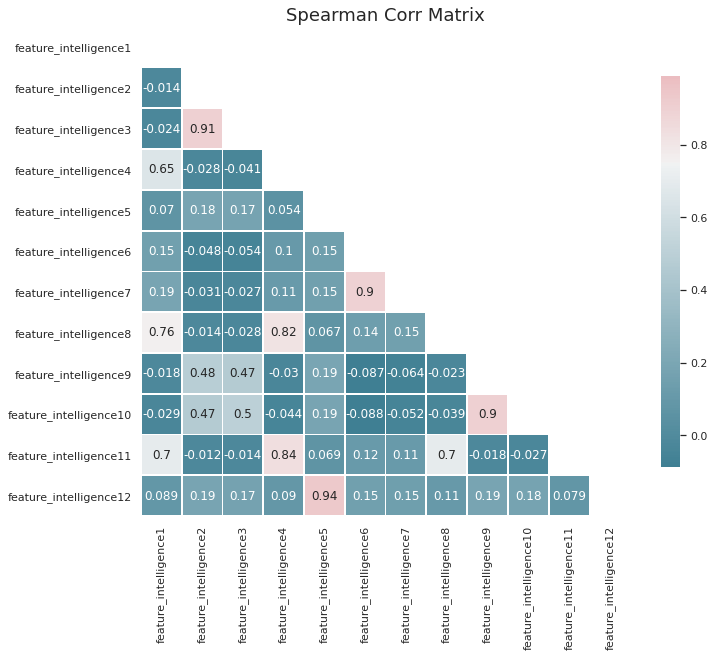

In [19]:
visualize.plot_corr_matrix(df_training[feature_intelligence])

In [33]:
print()
print()
print()
print()

### Essa correlação muda com o passar das eras

Comparamos a correlação de **pearson** nas primeira metade (eras 1-60), com a segunda metade (era 61-120)

In [18]:
eras = df_training.era
df1 = df_training[eras<=eras.median()]
df2 = df_training[eras>eras.median()]

In [20]:
corr1 = df1[feature_intelligence].corr().unstack()
corr1 = corr1[corr1.index.get_level_values(0) < corr1.index.get_level_values(1)]

In [21]:
corr2 = df2[feature_intelligence].corr().unstack()
corr2 = corr2[corr2.index.get_level_values(0) < corr2.index.get_level_values(1)]

In [24]:
tdf = pd.DataFrame({
    "corr1": corr1,
    "corr2": corr2,
})
tdf["corr_diff"] = tdf.corr2 - tdf.corr1
tdf.sort_values(by="corr_diff").head().style.set_properties(**{'font-size': '20 pt'})

#### O relacionamento entre as variáveis é inconsistente

## Sobre o target

* Proporção dos valores do target é similar ao *Numerai Signals*
* A Quantidade de ações monitorada dentro das 120 eras (mensais) é variável.

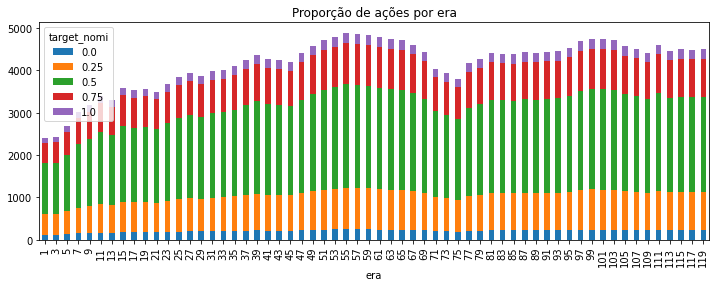

In [40]:
targets = df_training.loc[:, ['era', target]]
pivot_target = targets.groupby(['era', target]).apply(lambda x: len(x)).reset_index(1).pivot(columns=target,values=0)
pivot_target.iloc[::2].plot(kind='bar', stacked=True, figsize=(12,4), title='Proporção de ações por era');

#### Lembrando toda era começa na sexta feira e precisamos prever o retorno de cada ação para o período subsequente

## Algumas features possuem correlação com o target

In [159]:
df = df_training.copy()
eras = df_training.era

In [14]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [35]:
feature_scores = {
    feature: numerai_score(df[target], df[feature])
    for feature in features
}

In [45]:
pd.Series(feature_scores).sort_values(ascending=False)

feature_strength34     0.0123
feature_strength14     0.0115
feature_charisma37     0.0110
feature_charisma18     0.0108
feature_charisma76     0.0107
                        ...  
feature_dexterity11   -0.0102
feature_charisma69    -0.0103
feature_dexterity4    -0.0110
feature_dexterity6    -0.0111
feature_dexterity7    -0.0115
Length: 310, dtype: float64

### Lembre-se que a relação sinal-ruído é extramamente baixa

### Como uma feature se comporta com relação ao target por era

Lembrete: Uma feature é um indicador financeiro

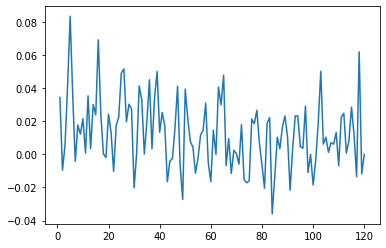

In [39]:
# Single features do not work consistently though
by_era_correlation = pd.Series({
    era: np.corrcoef(tdf['target_kazutsugi'], tdf["feature_strength34"])[0,1]
    for era, tdf in df.groupby(eras)
})
by_era_correlation.plot();

#### Analisando a média movel de 12 eras (1 ano)

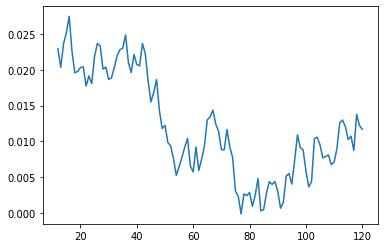

In [44]:
# With a rolling 12 era average you can see some trends
by_era_correlation.rolling(12).mean().plot();

### Conclusão: Não podemos confiar demais em um grupo pequeno de features

## Como somos Avaliados?

<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap3/integration_test.png?raw=true" width=800 />

- Equivale a um retorno de 8.5% a cada NMR investido (1NMR=25USD)

*Fonte: https://numer.ai/integration_test*

### Baseline

#### Modelo do Integration Test

In [136]:
print("XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, colsample_bytree=0.1)")

XGBRegressor(n_estimators=2000, learning_rate=0.01, max_depth=5, colsample_bytree=0.1)


### Lembrando que o target assume os valores  {0, 0,25, 0,5, 0,75, 1}

#### Mas a avaliação é feita sobre a correlação de spearman

### Correlação de Spearman

$${\displaystyle r_{s}=\rho _{\operatorname {rg} _{X},\operatorname {rg} _{Y}}={\frac {\operatorname {cov} (\operatorname {rg} _{X},\operatorname {rg} _{Y})}{\sigma _{\operatorname {rg} _{X}}\sigma _{\operatorname {rg} _{Y}}}},}$$





<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/spearman.png?raw=true" width=350 />



#### entao estamos resolvendo um problema de ranqueamento

*Fonte: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient*

### Tipos de Aprendizado Supervisionado

#### Regressão e Classificação
<img src="https://miro.medium.com/max/3200/1*ASYpFfDh7XnreU-ygqXonw.png" style="width: 700px;"/> 

*Fonte: https://medium.com/opensanca/aprendizagem-de-maquina-supervisionada-ou-n%C3%A3o-supervisionada-7d01f78cd80a*

#### Ranqueamento

<td> <img src="https://i1.wp.com/mlexplained.com/wp-content/uploads/2019/05/Screen-Shot-2019-05-24-at-10.53.30-PM.png?resize=840%2C434" alt="Drawing" style="width: 500px;"/> </td>

*Fonte: https://mlexplained.com/2019/05/27/learning-to-rank-explained-with-code/*

#### Podemos fazer das três formas

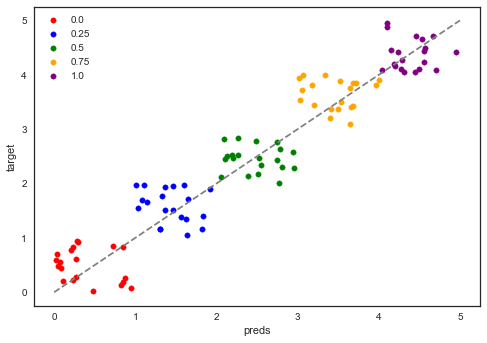

In [156]:
plt.style.use('seaborn-white')

X = []
for i in range(5):
    X +=[[i+random.random(),i+random.random(),i/4] for _ in range(20)]

    
X = np.array(X)
df = pd.DataFrame(dict(preds=X[:,0], target=X[:,1], label=X[:,2]))
colors = {0:'red', .25:'blue', .5:'green', .75:'orange', 1:'purple'}


fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='preds', y='target', label=key, color=colors[key], s=30)

    
dash = np.linspace(0,5,100)
plt.plot(dash, dash, color='grey', linestyle='dashed')
plt.show()

### Qual dos três é o melhor?

###### Utilizamos 3 modelos top de linha e vamos comparar as implementações de classificação, regressão e ranqueamento.

- Xgboost (Microsoft)
- LightGBM (Microsoft)
- Catboost (Yandex)

In [ ]:
model_name = [
              "XGBClassifier"
              ,"XGBRegressor"
              ,"XGBRanker"
              ,"LGBMClassifier"
              ,"LGBMRegressor"
              ,"LGBMRanker"
              ,"CatBoostClassifier"
              ,"CatBoostRegressor"              
]

In [ ]:
est = 2000
models = [
    XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0),
    XGBRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, tree_method='gpu_hist', gpu_id=0)
] +  [
    LGBMClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu"),
    LGBMRanker(max_depth=5, learning_rate=0.01, n_estimators=est, n_jobs=-1, colsample_bytree=0.1, num_leaves=32, device_type = "gpu")
] +  [
    CatBoostClassifier(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU'),
    CatBoostRegressor(max_depth=5, learning_rate=0.01, n_estimators=est, task_type='GPU')
]

In [ ]:
results = dict()
from time import time

for i,model in enumerate(models):
    model_res = dict()
    print(" -- ", model)
    start = time()
    if model_name[i] == "XGBRanker" or model_name[i] == "LGBMRanker":
      model.fit(training_data[features], training_data[target], group=group)
    else:
      model.fit(training_data[features], training_data[target])
    elapsed = time() - start
    model_res["outsample"] = numerai_score(df2[target], pd.Series(model.predict(df2[features]).reshape(1,-1)[0], index=df2.index))
    model_res["insample"] = numerai_score(df1[target], pd.Series(model.predict(df1[features]).reshape(1,-1)[0], index=df1.index))
    model_res["time_elapsed(s)"] = elapsed
    print(
        #f"outsample: {model_res["outsample"]}, insample: {model_res["insample"]}"
    )
    print()
    results[model_name[i]] = model_res
    file_name = 'baseline_'+ model_name[i] +'.pkl'
    dump(model, file_name)

res = pd.DataFrame.from_dict(results).T
pd.set_option("display.precision", 4)

final_results = res.sort_values(by=['outsample'], ascending=False)
#final_results.to_csv("results_baseline.csv", index=True)

 --  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
[16:58:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.




In [138]:
#res.sort_values(by=['time_elapsed(s)'])
results = pd.read_csv("../../reports/results_baseline.csv")

#### Treinamos nas eras 1-60 e testamos nas eras 61-120

In [194]:
results.sort_values(by=['outsample'], ascending=False).style.set_properties(**{'font-size': '30 pt'})


,outsample,insample,time_elapsed_GPU(s),time_elapsed(s)
LGBMRegressor,0.0447,0.2677,23.8324,62.3275
XGBRanker,0.0442,0.2021,67.5707,469.0444
XGBRegressor,0.0440,0.2667,37.2466,445.6100
LGBMClassifier,0.0305,0.2070,137.1966,301.8254
XGBClassifier,0.0302,0.1648,232.9470,2172.2911
CatBoostClassifier,0.0271,0.0959,19.0138,1193.6433
CatBoostRegressor,0.0267,0.0949,9.2403,209.8839
LGBMRanker,0.0150,0.0647,6092.7200,16133.8554


### Avaliando Modelo de  Classificação (LGBM Classifier)

In [ ]:
preds = models["LGBMClassifier"].predict(df_validation[features])

              precision    recall  f1-score   support

           0       0.27      0.28      0.28     21352
           1       0.23      0.15      0.18     21363
           2       0.27      0.36      0.31     21474
           3       0.22      0.15      0.18     21362
           4       0.27      0.35      0.30     21344

    accuracy                           0.26    106895
   macro avg       0.25      0.26      0.25    106895
weighted avg       0.25      0.26      0.25    106895



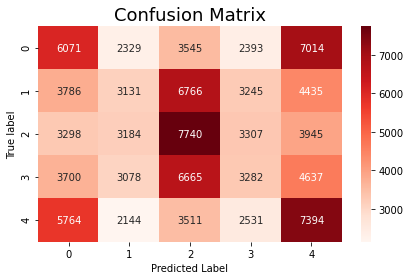

In [ ]:
evaluation.plot_confusion_matrix(lab_enc.fit_transform(df_validation[target]), preds/4)

### Os extremos e o meio das predições são muito correlacionados

array([[ 1.        , -0.81393351, -0.8942065 , -0.88654085,  0.78328667],
       [-0.81393351,  1.        ,  0.80874765,  0.72378902, -0.89877694],
       [-0.8942065 ,  0.80874765,  1.        ,  0.77462933, -0.90867348],
       [-0.88654085,  0.72378902,  0.77462933,  1.        , -0.80042416],
       [ 0.78328667, -0.89877694, -0.90867348, -0.80042416,  1.        ]])

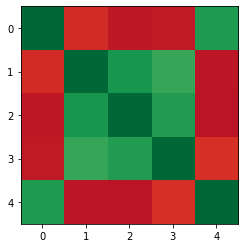

In [ ]:
corrs=np.corrcoef(model.predict_proba(df_validation[features]).T)
plt.imshow(corrs, vmin=-1, vmax=1, cmap="RdYlGn")
corrs

#### Modelos de classificação performam pior que os outros!

## Como treinar os modelos (validação)

<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/k_fold.png?raw=true" title="xxxx" alt="Drawing" style="width: 500px;"/>
    
  
<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/group_kfold.png?raw=true" alt="Drawing" style="width: 500px;"/>
    
    
 
 <img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/ts_kfold.png?raw=true" alt="Drawing" style="width: 500px;"/>




*Fonte: https://scikit-learn.org/stable/modules/cross_validation.html*

In [151]:
print()
print()
print()
print()

### Comparando Esquemas de Validação
<table><tr>

<td> <img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/k_fold.png?raw=true" title="xxxx" alt="Drawing" style="width: 500px;"/> </td>
    
  
<td> <img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/group_kfold.png?raw=true" alt="Drawing" style="width: 500px;"/> </td>
    
    
 
<td> <img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/ts_kfold.png?raw=true" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>


In [58]:
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm
)

In [ ]:
crossvalidators = [
    model_selection.KFold(5),
    model_selection.KFold(5, shuffle=True),
    model_selection.GroupKFold(5),
    model_selection.TimeSeriesSplit(5)
]

In [163]:
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

#### 5-fold com e sem embaralhar

In [ ]:
for cv in crossvalidators:
    print(cv)
    print(np.mean(
            model_selection.cross_val_score(
            linear_model.LinearRegression(),
            df[features],
            df[target],
            cv=cv,
            n_jobs=1,
            groups=eras,
            scoring=metrics.make_scorer(correlation_score, greater_is_better=True)
        )))
    print()

KFold(n_splits=5, random_state=None, shuffle=False)
0.03658489467457003

KFold(n_splits=5, random_state=None, shuffle=True)
0.04360860798952288

GroupKFold(n_splits=5)
0.038069863851659315

TimeSeriesSplit(max_train_size=None, n_splits=5)
0.033943838232674675



### Como interpretar as eras

- Algumas eras são menos aplicáveis do que outras eras (regimes diferentes)


Vamos treinar um modelo em cada grupo de 10 eras e testar nas restantes

In [198]:
eras10 = (eras // 10) * 10
#eras10.value_counts()

In [ ]:
from sklearn.linear_model import LinearRegression
results10 = []
for train_era, tdf in df[eras10<120].groupby(eras10):
    print(train_era)
    model = LinearRegression()
    model.fit(tdf[features], tdf[target])
    for test_era, tdf in df[eras10<120].groupby(eras10):
        results10.append([
            train_era,
            test_era,
            correlation_score(tdf[target], model.predict(tdf[features]))
        ])

In [197]:
results_df = pd.DataFrame(
    results10,
    columns=["train_era", "test_era", "score"]
).pivot(index="train_era", columns="test_era", values="score")
#results_df

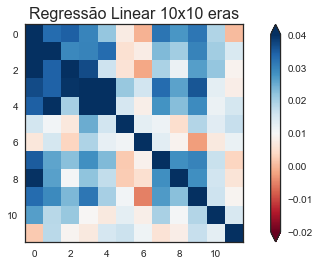

In [211]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 4), ncols=1)
ax.set_title('Regressão Linear 10x10 eras', fontsize=16)
pos_neg_clipped = ax.imshow(results_df, cmap='RdBu', vmin=-.02, vmax=.04)
cbar = fig.colorbar(pos_neg_clipped, ax=ax, extend='both')
cbar.minorticks_on()
plt.show()

- As eras do meio não parecem ser relevantes para as outras eras
- A performance do modelo parece decair ao longo do tempo

In [200]:
print()
print()
print()
print()

Here is an advanced paper that talks about generalization.
Eras can be thought about in the same way that "distributions" or "environments" are talked about here
https://arxiv.org/pdf/1907.02893.pdf

# Padrão dos Modelos

Os modelos seguirao o padrao NR__<"Nome_Cidade">



# NR__RIO


<img src="https://diariodorio.com/wp-content/uploads/2019/02/rio-de-janeiro-juntos-pelo-rio.jpg" alt="Drawing" style="width: 500px;"/>



### Descrição NR__RIO

- Modelo LGBMRegressor (o melhor testado até aqui)
- Validação 3-Group Kfold
- Com Otimização de Hiperparâmetros

In [26]:
print("LGBMRegressor(n_estimators=3135, learning_rate=0.0064, num_leaves=226,...)")

LGBMRegressor(n_estimators=3135, learning_rate=0.0064, num_leaves=226,...)


### Como testar o modelo

- Usaremos o dataset de "validação"
- Eras 121 a 206 (dados do futuro)

In [15]:
df_validation.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n0003aa52cab36c2,121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


### Dataset Validação
<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap2/df_validation.png?raw=true" alt="Drawing" style="width: 350px;"/>

In [37]:
path = '../../Data/processed/predicoes_validacao/'
models_nr = ['ex_preds', 'NR_Rio']


from src.validation import metrics
from src.validation import metrics_description

preds_nr, feat_corrs_nr = dict(), dict()
era_scores_nr, df_metrics_nr = dict(), dict()

for model in models_nr[1:]:
    
    #predicoes val1 & val2
    print("creating predictions to:", model)
    preds_nr[model] =  pd.read_csv(path+model+'_preds_test.csv', index_col='id').values.reshape(1,-1)[0]
    
    #salvando as metricas
    era_scores_nr[model], df_metrics_nr[model], feat_corrs_nr[model], ex_preds = \
                        metrics.submission_metrics(df_validation, preds_nr[model], model, True)   



#add ex_preds
print("creating predictions to: ex_preds")
preds_nr['ex_preds'] = np.array(ex_preds)
era_scores_nr['ex_preds'], df_metrics_nr['ex_preds'], feat_corrs_nr['ex_preds'], ex_preds = \
                        metrics.submission_metrics(df_validation, preds_nr['ex_preds'], "ex_preds", False)



#dict to dataframe
df_preds_nr = pd.DataFrame.from_dict(preds_nr)  
df_era_scores_nr = pd.DataFrame.from_dict(era_scores_nr)
df_feat_corrs_nr = pd.DataFrame.from_dict(feat_corrs_nr)
df_metrics_cons_nr = metrics.metrics_consolidated(df_metrics_nr)

creating predictions to: NR_Rio
creating predictions to: ex_preds


### Avaliando nos dados de teste

In [38]:
visualize.plot_era_scores(df_era_scores_nr, models_nr)

In [25]:
#visualize.plot_feat_cors(df_feat_corrs_nr, models_nr)

### Diagnóstico do modelo

<img src="https://github.com/nicholasrichers/dissertacao/blob/master/references/figures/cap3/diagnostics.png?raw=true" alt="Drawing" style="width: 250px;"/>



### Comparando com o baseline

In [39]:
print("Menor é melhor:", min_cols)
leaderboard_nr = df_metrics_cons_nr[df_metrics_cons_nr.Categoria.isin(["Performance", "Risk", "MMC"])].loc[:,models_nr]
leaderboard_nr.astype(float).style.apply(visualize.highlight_max, axis = 1)

Menor é melhor: ['Feat_exp_max', 'Std_Dev', 'corr_with_example_preds']


,ex_preds,NR_Rio
Metrica,,
Validation_Sharpe,0.9588,1.1423
Validation_Mean,0.0289,0.0299
Feat_neutral_mean,0.0000,0.0259
Validation_SD,0.0301,0.0262
Feat_exp_max,0.2917,0.2526
Max_Drawdown,-0.0775,-0.0511
corr_plus_mmc_sharpe,0.0000,1.2072
val_mmc_mean,0.0000,0.0055
corr_with_example_preds,1.0000,0.8791


### Superamos o baseline da numerai com "facilidade"

# Create Slides

In [41]:
!jupyter nbconvert Cap3_Dados.ipynb --to slides  --template output_toggle  --SlidesExporter.reveal_scroll=True --SlidesExporter.reveal_theme=white  #--reveal-prefix=reveal.js --post serve

[NbConvertApp] Converting notebook Cap3_Dados.ipynb to slides
[NbConvertApp] Writing 627417 bytes to Cap3_Dados.slides.html


In [60]:
import plotly.graph_objects as go
import plotly.io as pio

# Set default renderer
pio.renderers.default = 'notebook+jupyterlab'  #  See [1]

# Set default template
pio.templates['slides'] = go.layout.Template(layout=dict(width=900, height=600))
pio.templates.default = 'plotly+slides'  # See [2]

In [ ]:
#configuração da dimensões da tela de apresentação
from notebook.services.config import ConfigManager
cm = ConfigManager()

#defina as dimensões da apresentação.
cm.update('livereveal', {
              'width': 1024,
              'height': 768,
              'scroll': True,
              'transition': 'slide',
              "theme": "white",
               "autolaunch": False
         })


#"rise": {"enable_chalkboard": True}
# themes path /Users/nicholasrichers/Documents/virtualenvs/numerai_env/share/jupyter/nbextensions/rise/reveal.js/css/theme

In [ ]:
#df_training.iloc[0:2,0:2].to_markdown()